In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import sys
# !{sys.executable} -m pip install pmdarima
import pmdarima as pm

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import collections
tf.enable_v2_behavior()

## Load Data

In [3]:
# df_prop = pd.read_csv("data/Denver-MLS/boston_property_info.csv")
# df = pd.read_csv("../data/Denver-MLS/denver_listing_dates.csv")
url = 'https://drive.google.com/file/d/19_JeXh3Ost8q7XyX-ZmnDPLCLKy7HC00/view?usp=sharing'
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url)

In [4]:
df.zipcode = df.zipcode.astype("str")
df['list_month']=pd.to_datetime(df.list_date) + pd.offsets.MonthBegin(0)
df['sale_month']=pd.to_datetime(df.sale_date) + pd.offsets.MonthBegin(0)
display(df.head())

,property_id,zipcode,latitude,longitude,list_date,sale_date,withdrawn_date,expired_date,cancelled_date,current_status,sale_price,geometry,index_right,ct_key,list_month,sale_month
0,139863800,80112,39.58203,-104.92111,2016-03-01,2016-03-01,NaN,NaN,NaN,Sale,475000.0,POINT (-104.92111 39.58203),10690.0,8.005007e+09,2016-03-01,2016-03-01
1,139817027,80112,39.56911,-104.80082,2016-03-01,2016-04-08,NaN,NaN,NaN,Sale,295000.0,POINT (-104.80082 39.56911),10769.0,8.005007e+09,2016-03-01,2016-05-01
2,482086548,80138,39.49819,-104.73505,2016-03-01,2016-05-19,NaN,NaN,NaN,Sale,412000.0,POINT (-104.73505 39.49819),10115.0,8.035014e+09,2016-03-01,2016-06-01
3,494122461,80211,39.75414,-105.03118,2016-03-01,NaN,NaN,2016-03-01,NaN,Expired,NaN,POINT (-105.03118 39.75414),10477.0,8.031001e+09,2016-03-01,NaT
4,523793691,80516,40.09353,-104.99471,2016-03-01,2016-04-15,NaN,NaN,NaN,Sale,398000.0,POINT (-104.99471 40.09353),10342.0,8.123002e+09,2016-03-01,2016-05-01


## Distribution per City, Zipcode

In [5]:
df_listing = df.groupby(["zipcode", "list_month"]).agg({"property_id":"count"}).reset_index()
df_listing = df_listing.rename(columns={"property_id":"count_listing"})

df_sale = df.groupby(["zipcode", "sale_month"]).agg({"property_id":"count", "sale_price":"sum"}).reset_index()
df_sale = df_sale.rename(columns={"property_id":"count_sale", "sale_price":"total_value"})

In [6]:
df_monthly = pd.merge(df_listing, df_sale, left_on = ['zipcode', 'list_month'], right_on = ['zipcode', 'sale_month'])
df_monthly = df_monthly.drop('list_month', axis=1)
df_monthly = df_monthly.rename(columns={'sale_month':'month'})
df_monthly.head()

,zipcode,count_listing,month,count_sale,total_value
0,80002,5,2016-03-01,2,647500.0
1,80002,40,2016-04-01,21,7822500.0
2,80002,29,2016-05-01,17,5915000.0
3,80002,47,2016-06-01,19,8517000.0
4,80002,39,2016-07-01,29,9983875.0


In [7]:
top10sales = list(df_monthly.groupby("zipcode").sum()['total_value'].sort_values(ascending=False).head(10).reset_index().zipcode)
top10unitSold = list(df_monthly.groupby("zipcode").sum()["count_sale"].sort_values(ascending=False).head(10).reset_index().zipcode)
top10listings = list(df_monthly.groupby("zipcode").sum()["count_listing"].sort_values(ascending=False).head(10).reset_index().zipcode)


### 1. Relationship with Population Density

In [8]:
# https://worldpopulationreview.com/zips/colorado
df_population = pd.read_csv("../data/Denver-MLS/population_colorado.csv")
df_population['zip'] = df_population['zip'].astype(str)
df_monthly_population = pd.merge(df_monthly, df_population, left_on="zipcode", right_on="zip")
df_monthly_population = df_monthly_population[df_monthly_population['pop']>0]
df_monthly_population.drop("zip", axis=1, inplace=True)

In [9]:
# eliminate the huge spike
for zipcode in df_monthly_population.zipcode.unique():
    df_interpolate = df_monthly_population[df_monthly_population['zipcode']==zipcode]
    try:
        val_interpolate = np.mean([df_interpolate[df_interpolate['month']=='2019-06-01']['count_listing'].values[0],
                                   df_interpolate[df_interpolate['month']=='2019-08-01']['count_listing'].values[0]])
        df_monthly_population.loc[(df_monthly_population['zipcode']==zipcode)&
                                  (df_monthly_population['month']=='2019-07-01'), 'count_listing'] = val_interpolate
    except:
        # if data does not exist, assume no listing
        df_monthly_population.loc[(df_monthly_population['zipcode']==zipcode)&
                                  (df_monthly_population['month']=='2019-07-01'), 'count_listing'] = 0
        

In [10]:
df_monthly_population["count_listing_normalized"] = df_monthly_population["count_listing"]/df_monthly_population["pop"]
df_monthly_population["count_sale_normalized"] = df_monthly_population["count_sale"]/df_monthly_population["pop"]
df_monthly_population["total_value_normalized"] = df_monthly_population["total_value"]/df_monthly_population["pop"]
df_monthly_population.head()

,zipcode,count_listing,month,count_sale,total_value,city,county,pop,count_listing_normalized,count_sale_normalized,total_value_normalized
0,80002,5.0,2016-03-01,2,647500.0,Arvada,Jefferson,18266,0.000274,0.000109,35.448374
1,80002,40.0,2016-04-01,21,7822500.0,Arvada,Jefferson,18266,0.002190,0.001150,428.254681
2,80002,29.0,2016-05-01,17,5915000.0,Arvada,Jefferson,18266,0.001588,0.000931,323.825687
3,80002,47.0,2016-06-01,19,8517000.0,Arvada,Jefferson,18266,0.002573,0.001040,466.276141
4,80002,39.0,2016-07-01,29,9983875.0,Arvada,Jefferson,18266,0.002135,0.001588,546.582448


In [19]:
# drop the data for the first month, which seems problematic
df_monthly_population = df_monthly_population[(df_monthly_population.month > '2016-03-01')&
                                              (df_monthly_population.month < '2020-11-01')]

#### By County

In [20]:
# aggregate by county
agg_measures = {measure:'sum' for measure in ['count_listing','count_sale','total_value']}

df_monthly_population_county = df_monthly_population.groupby(['month', 'county']).agg(agg_measures).reset_index()
df_monthly_population_county = pd.merge(df_monthly_population_county, df_population.groupby('county').sum()['pop'], 
                                        left_on='county', right_index=True)

df_monthly_population_county["count_listing_normalized"] = df_monthly_population_county["count_listing"]/df_monthly_population_county["pop"]
df_monthly_population_county["count_sale_normalized"] = df_monthly_population_county["count_sale"]/df_monthly_population_county["pop"]
df_monthly_population_county["total_value_normalized"] = df_monthly_population_county["total_value"]/df_monthly_population_county["pop"]

df_monthly_population_county.head()

,month,county,count_listing,count_sale,total_value,pop,count_listing_normalized,count_sale_normalized,total_value_normalized
0,2016-04-01,Adams,1738.0,766,224949388.0,514441,0.003378,0.001489,437.269557
8,2016-05-01,Adams,1295.0,720,218171526.0,514441,0.002517,0.001400,424.094359
16,2016-06-01,Adams,1187.0,898,278805974.0,514441,0.002307,0.001746,541.959086
24,2016-07-01,Adams,1262.0,901,289006710.0,514441,0.002453,0.001751,561.787863
32,2016-08-01,Adams,1042.0,873,264752324.0,514441,0.002025,0.001697,514.640793


Text(0, 0.5, 'Number of Listings per month')

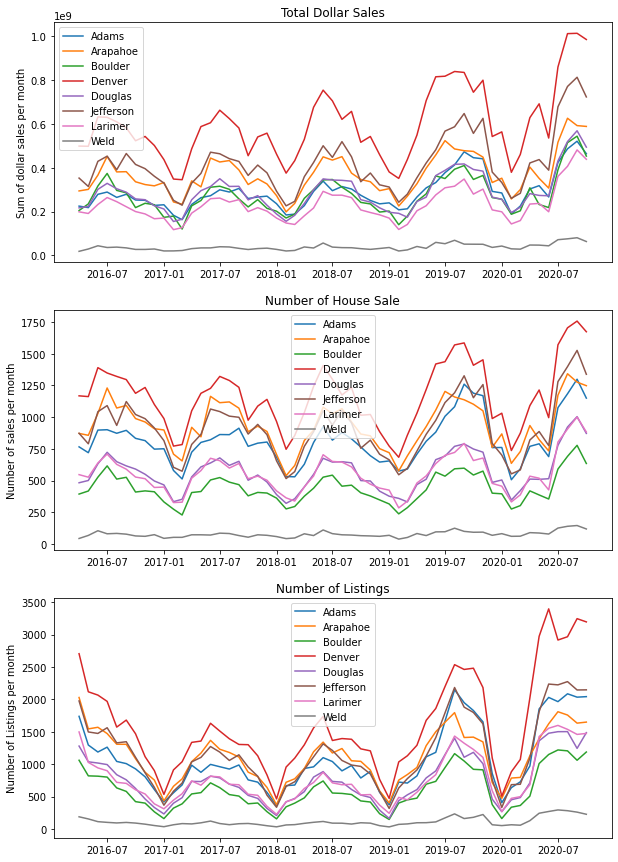

In [21]:
# Unnormalized metric - all values are raw values
fig, ax = plt.subplots(3,1,figsize=(10,15))
for county in df_monthly_population_county.county.unique():
    df_plot = df_monthly_population_county[df_monthly_population_county["county"]==county]
    ax[0].plot(df_plot['month'], df_plot["total_value"], label=county)
ax[0].legend()
ax[0].set_title("Total Dollar Sales")
ax[0].set_ylabel("Sum of dollar sales per month")

for county in df_monthly_population_county.county.unique():
    df_plot = df_monthly_population_county[df_monthly_population_county["county"]==county]
    ax[1].plot(df_plot['month'], df_plot["count_sale"], label=county)
ax[1].legend()
ax[1].set_title("Number of House Sale")
ax[1].set_ylabel("Number of sales per month")

for county in df_monthly_population_county.county.unique():
    df_plot = df_monthly_population_county[df_monthly_population_county["county"]==county]
    ax[2].plot(df_plot['month'], df_plot["count_listing"], label=county)
ax[2].legend()
ax[2].set_title("Number of Listings")
ax[2].set_ylabel("Number of Listings per month")

#### Overall - For Denver Market Area

In [25]:
ts_denver = np.array(df_monthly_population.groupby('month').sum()['total_value'].values, dtype='float')
ts_denver_countsale = np.array(df_monthly_population.groupby('month').sum()['count_sale'].values, dtype='float')
ts_denver_countlisting = np.array(df_monthly_population.groupby('month').sum()['count_listing'].values, dtype='float')

ts_dates = np.arange("2016-04", "2020-11", dtype="datetime64[M]")

assert(len(ts_denver) == len(ts_dates))
assert(len(ts_denver_countsale) == len(ts_dates))
assert(len(ts_denver_countlisting) == len(ts_dates))

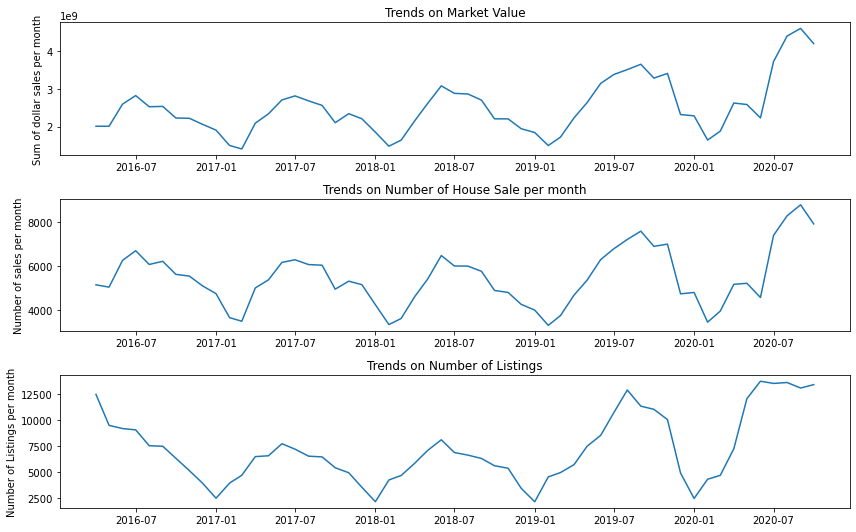

In [28]:
fig, ax = plt.subplots(3,1,figsize=(12,7.5))

ax[0].plot(ts_dates, ts_denver, label="total_value")
ax[0].set_title("Trends on Market Value")
ax[0].set_ylabel("Sum of dollar sales per month")

ax[1].plot(ts_dates, ts_denver_countsale, label="count_sale")
ax[1].set_title("Trends on Number of House Sale per month")
ax[1].set_ylabel("Number of sales per month")

ax[2].plot(ts_dates, ts_denver_countlisting, label="count_listings")
ax[2].set_title("Trends on Number of Listings")
ax[2].set_ylabel("Number of Listings per month")

plt.tight_layout()


## Baseline Forecast per city, zipcode with ARIMA (not used/not updated)

### 1. Forecast for Number of Listings

 ARIMA(0,1,0)(0,1,0)[12]          


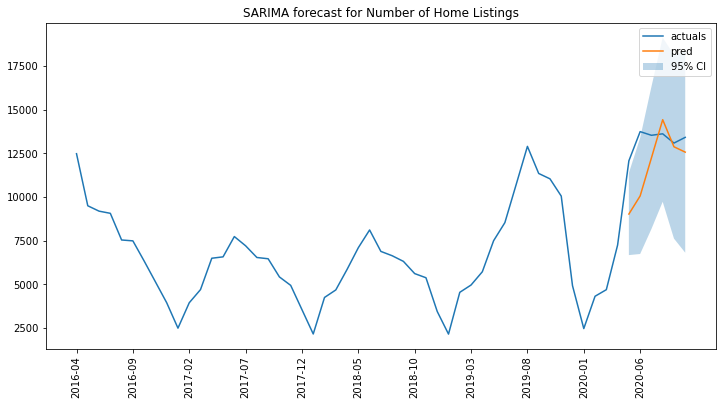

In [32]:
num_forecast_steps = 6

model = pm.auto_arima(ts_denver_countlisting[:-num_forecast_steps], seasonal=True, m=12)
print(model)
pred, CI = model.predict(num_forecast_steps, return_conf_int=True)

fig, ax = plt.subplots(1,1,sharex=True, figsize=(12,6))
ax.plot(range(len(ts_dates)), ts_denver_countlisting, label="actuals")
ax.plot(range(len(ts_dates)-n_periods,len(ts_dates)), pred, label="pred")
ax.fill_between(range(len(ts_dates)-n_periods,len(ts_dates)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
ax.set_xticks(range(len(ts_dates))[::5])
ax.set_xticklabels(ts_dates[::5], rotation=90)
ax.set_title("SARIMA forecast for Number of Home Listings")
ax.legend()

### 2. Forecast for Number of Units Sold¶

 ARIMA(0,1,0)(0,1,0)[12]          


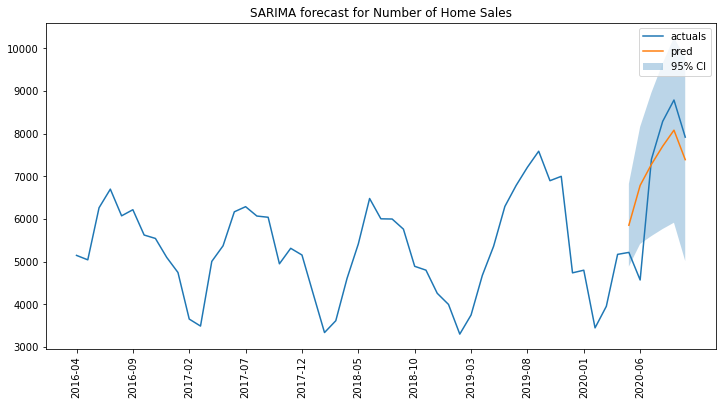

In [33]:
num_forecast_steps = 6

model = pm.auto_arima(ts_denver_countsale[:-num_forecast_steps], seasonal=True, m=12)
print(model)
pred, CI = model.predict(num_forecast_steps, return_conf_int=True)

fig, ax = plt.subplots(1,1,sharex=True, figsize=(12,6))
ax.plot(range(len(ts_dates)), ts_denver_countsale, label="actuals")
ax.plot(range(len(ts_dates)-n_periods,len(ts_dates)), pred, label="pred")
ax.fill_between(range(len(ts_dates)-n_periods,len(ts_dates)),CI[:,0], CI[:,1], alpha=0.3, label=("95% CI"))
ax.set_xticks(range(len(ts_dates))[::5])
ax.set_xticklabels(ts_dates[::5], rotation=90)
ax.set_title("SARIMA forecast for Number of Home Sales")
ax.legend()

## Forecasting with Bayesian Structural Time Series

Utils function:

In [34]:
# code snippets credits to MarkDaoust:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast


    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components,1,1+i)
        ax.plot(dates, component_mean, lw=2)
        ax.fill_between(dates,
                         component_mean-2*component_stddev,
                         component_mean+2*component_stddev,
                         color=c2, alpha=0.5)
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig=plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1,1,1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
        fig.tight_layout()
    return fig, ax

In [36]:
def build_variational_posteriors(denver_model, denver_training_data, 
                                 optimizer = tf.optimizers.Adam(learning_rate=.05),
                                 plot = True, nsamples=50
                                ):
    # Build the variational surrogate posteriors `qs`.
    variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=denver_model)

    # Allow external control of optimization to reduce test runtimes.
    num_variational_steps = 200 # @param { isTemplate: true}
    num_variational_steps = int(num_variational_steps)
    # Using fit_surrogate_posterior to build and optimize the variational loss function.
    @tf.function(experimental_compile=True)
    def train():
        elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=denver_model.joint_log_prob(observed_time_series=denver_training_data),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
        return elbo_loss_curve

    elbo_loss_curve = train()
    
    if plot:
        plt.plot(elbo_loss_curve)
        plt.title("ELBO loss curve")
        plt.show()

    # Draw samples from the variational posterior.
    q_samples_denver = variational_posteriors.sample(nsamples)
    
    return q_samples_denver

In [37]:
# forecasting
def draw_forecast(ts_denver, denver_model, denver_training_data, q_samples_denver, num_forecast_steps, 
                  ts_dates = ts_dates, area='Denver', metric='Total dollar sales', num_samples=50, return_fig=False):
    denver_forecast_dist = tfp.sts.forecast(denver_model, observed_time_series=denver_training_data,
                                            parameter_samples=q_samples_denver, num_steps_forecast=num_forecast_steps)

    denver_forecast_mean, denver_forecast_scale, denver_forecast_samples = (denver_forecast_dist.mean().numpy()[..., 0],
                                                                            denver_forecast_dist.stddev().numpy()[..., 0],
                                                                            denver_forecast_dist.sample(num_samples).numpy()[..., 0])

    fig, ax = plot_forecast(ts_dates, ts_denver, denver_forecast_mean, denver_forecast_scale, denver_forecast_samples,
                            # x_locator=ts_loc, x_formatter=ts_fmt, 
                            title = metric+" Forecast for "+area)
    ax.axvline(ts_dates[-num_forecast_steps], linestyle="--")
    ax.legend(loc="upper left")
    ax.set_ylabel(metric)
    ax.set_xlabel("date")
    fig.autofmt_xdate()
    
    if return_fig:
        return denver_forecast_mean, denver_forecast_scale, denver_forecast_samples, fig, ax
    else:
        plt.show()
        return denver_forecast_mean, denver_forecast_scale, denver_forecast_samples

### Build Model

### Model 1: LocalLinearTrend


We'll model this series with a local linear trend, plus a month-of-year seasonal effect.

We first try to model this time series data by the simplest bayesian structural time series model, which includes a **local linear trend** and **seasonal effect**.
The idea is that the local linear trend will capture and increasing or decresing trend that's happening in the market, while the seasonal effect will capture any fluctuations that happens yearly (e.g. market is relatively slower at the begininng of the year, and then peak up at the middle of the year, and slowing down again at the end of the year)

The model would be formulated as below:
$$y_t = \mu_t + \tau_t + \epsilon_t$$
$$\mu_{t+1} = \mu_t + \delta_t + \eta_{0t}$$
$$\delta_{t+1} = \delta_t + \eta_{1t}$$
$$\tau_{t+1} = -\sum_{s = 1}^{S-1}\tau_{t} + \eta_{2t}.$$

In this model, $y_t$ is our time series data. $\mu_t$ captures the latent long-term trend, and the value at each time point will depend on the previous state. There is an additional term $\delta_t$ which basically the amount of extra $\mu$ we can expect as  $t \rightarrow t+1$ , so it can be interpreted as the slope of the local linear trend. The slope evolves according to a random walk, which makes the trend an integrated random walk with an extra drift term.

$\tau_t$ captures the seasonal effect. We can specify $S=12$ to indicate we have monthly data with yearly seasonal effect. The noises/variances is compromised by $\epsilon_t \sim N(0, \sigma^2)$ and $\eta_t \sim N(0,  \tau^2)$
This local level model is basically a random walk observed in noise, plus seasonal effect.


In [35]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

### Model Fitting 

We'll fit the model using variational inference. This involves running an optimizer to minimize a variational loss function, the negative evidence lower bound (ELBO). This fits a set of approximate posterior distributions for the parameters (in practice we assume these to be independent Normals transformed to the support space of each parameter).

The `tfp.sts` forecasting methods require posterior samples as inputs, so we'll finish by drawing a set of samples from the variational posterior.

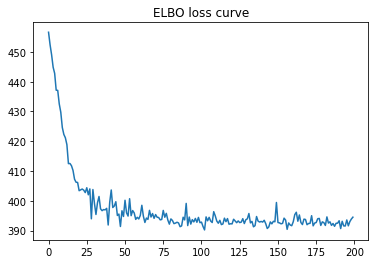

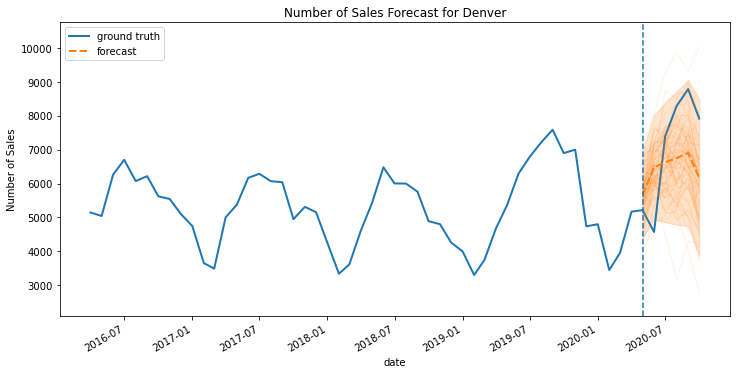

MSE for model1 - Count sale: 2.238e+06


In [273]:
denver_training_data = ts_denver_countsale[:-num_forecast_steps]

denver_model = build_model(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countsale, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Sales', 
                                                                                   num_samples=100)
print(f"MSE for model1 - Count sale: {mean_squared_error(ts_denver_countsale[-num_forecast_steps:],denver_forecast_mean):.3e}")


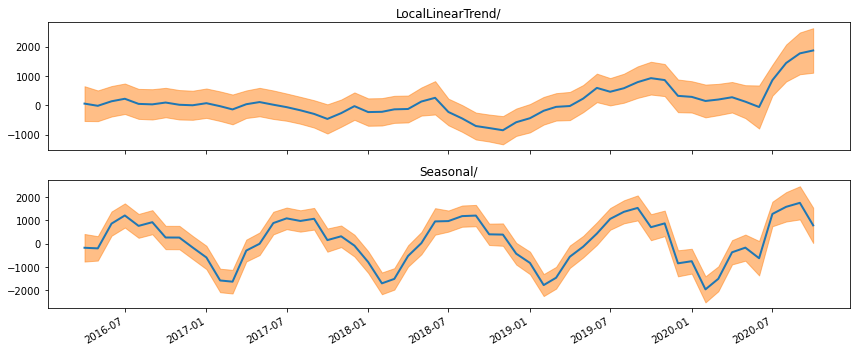

In [274]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countsale, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


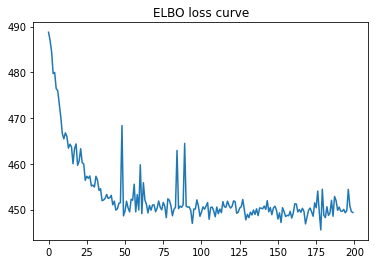

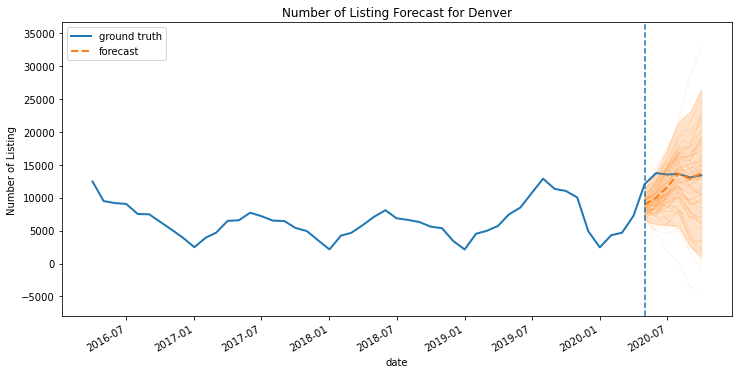

MSE for model1 - Count Listing: 4.588e+06


In [275]:
denver_training_data = ts_denver_countlisting[:-num_forecast_steps]

denver_model = build_model(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countlisting, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Listing', 
                                                                                   num_samples=100)
print(f"MSE for model1 - Count Listing: {mean_squared_error(ts_denver_countlisting[-num_forecast_steps:],denver_forecast_mean):.3e}")


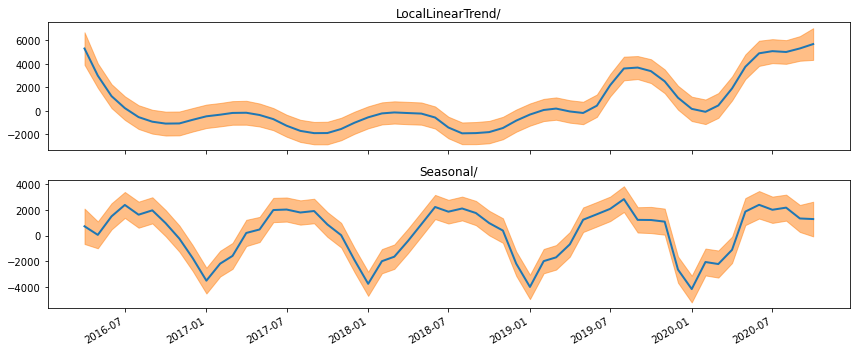

In [276]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countlisting, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


### Model 2: Using SemiLocalLinearTrend


In SemiLocalLinearTrend, we have the same exact equation as above, except for the slope. We replace the random walk on the slope with a stationary AR(1) process, while keeping the random walk for the level of the process. 
$$\delta_{t+1} = D + \rho (\delta_t - D) + \eta_{1t}$$
The $D$ parameter is the long run slope of the trend component, to which $\delta_t$  will eventually revert. However  $\delta_t$  can have short term autoregressive deviations from the long term trend, with memory determined by $\rho $. Values of  $\rho$  close to 1 will lead to long deviations from $D$ .

The Final Formulation of the model is below:

The model would be formulated as below:
$$y_t = \mu_t + \tau_t + \epsilon_t$$
$$\mu_{t+1} = \mu_t + \delta_t + \eta_{0t}$$
$$\delta_{t+1} = D + \rho (\delta_t - D) + \eta_{1t}$$
$$\tau_{t+1} = -\sum_{s = 1}^{S-1}\tau_{t} + \eta_{2t}.$$


In [39]:
def build_model2(observed_time_series):
    trend = sts.SemiLocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

Prediction for Number of Sales

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_

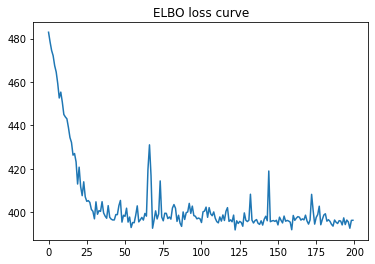

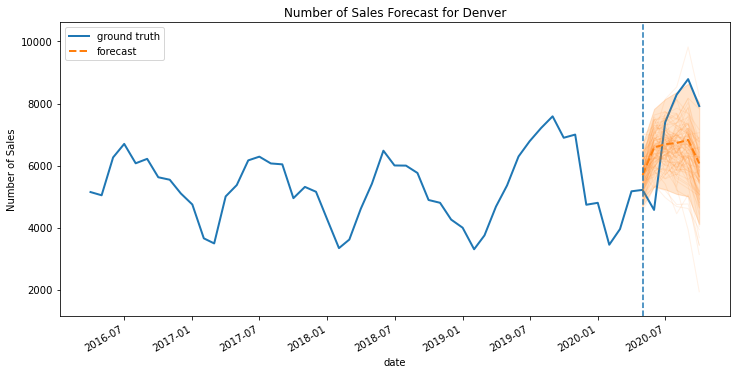

MSE for model2 - Count Sale: 2.409e+06


In [40]:
denver_training_data = ts_denver_countsale[:-num_forecast_steps]

denver_model = build_model2(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countsale, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Sales', 
                                                                                   num_samples=100)
print(f"MSE for model2 - Count Sale: {mean_squared_error(ts_denver_countsale[-num_forecast_steps:],denver_forecast_mean):.3e}")


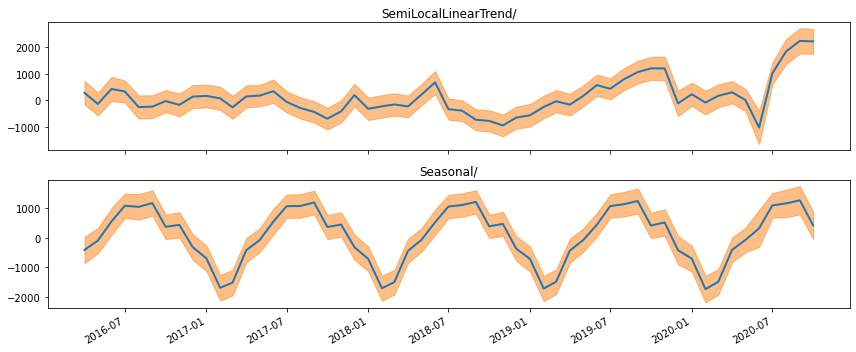

In [270]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countsale, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


Text(0.5, 0.98, 'One-step-ahead prediction for Number of Sales')

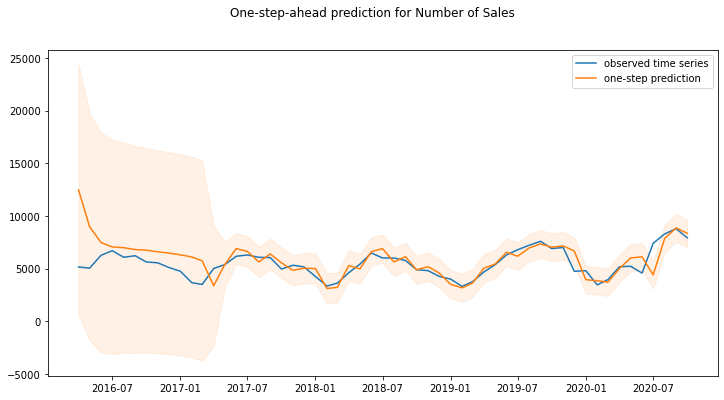

In [59]:
denver_one_step_dist = sts.one_step_predictive(denver_model, observed_time_series=ts_denver_countsale,
                                               parameter_samples=q_samples_denver)

denver_one_step_mean, denver_one_step_scale = (denver_one_step_dist.mean().numpy(), 
                                               denver_one_step_dist.stddev().numpy())

fig, ax = plot_one_step_predictive(ts_dates, ts_denver_countsale,
                                   denver_one_step_mean, denver_one_step_scale)
fig.suptitle("One-step-ahead prediction for Number of Sales")

Prediction for Number of Listings

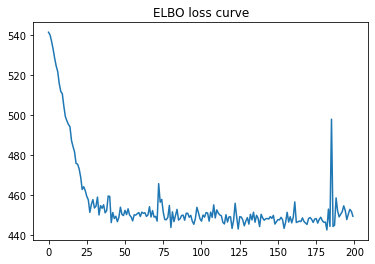

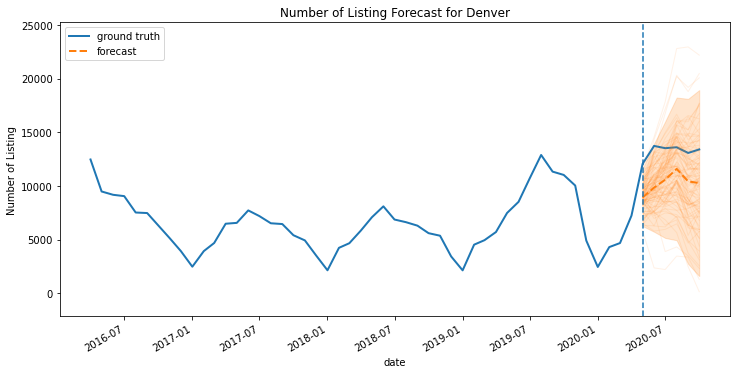

MSE for model2 - Count Listing: 9.077e+06


In [57]:
denver_training_data = ts_denver_countlisting[:-num_forecast_steps]

denver_model = build_model2(denver_training_data)
q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                plot = True, nsamples=50)
denver_forecast_mean, denver_forecast_scale, denver_forecast_samples=draw_forecast(ts_denver_countlisting, 
                                                                                   denver_model, denver_training_data,
                                                                                   q_samples_denver, num_forecast_steps,
                                                                                   ts_dates = ts_dates, 
                                                                                   area='Denver', metric='Number of Listing', 
                                                                                   num_samples=100)
print(f"MSE for model2 - Count Listing: {mean_squared_error(ts_denver_countlisting[-num_forecast_steps:],denver_forecast_mean):.3e}")


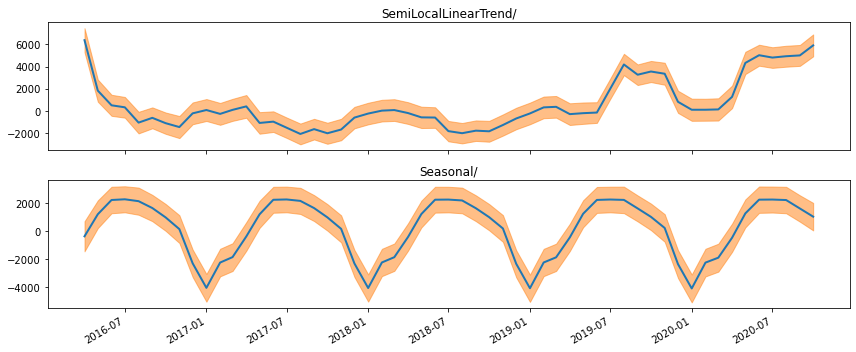

In [272]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(denver_model, observed_time_series=ts_denver_countlisting, 
                                             parameter_samples=q_samples_denver)
component_means_, component_stddevs_ = ({k.name: c.mean() for k, c in component_dists.items()},{k.name: c.stddev() for k, c in component_dists.items()})
_ = plot_components(ts_dates, component_means_, component_stddevs_)


Text(0.5, 0.98, 'One-step-ahead prediction for Number of Listing')

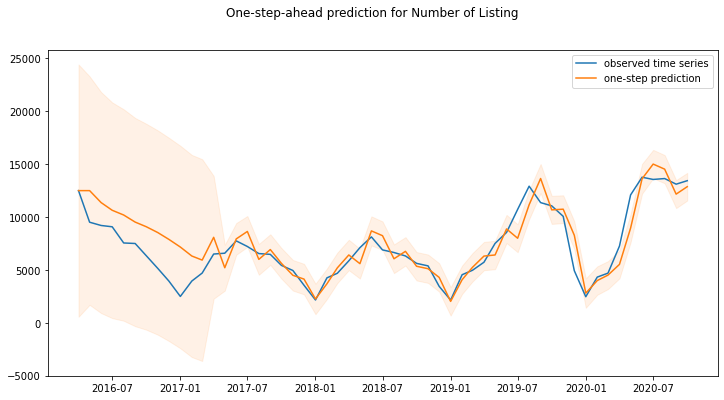

In [58]:
denver_one_step_dist = sts.one_step_predictive(denver_model, observed_time_series=ts_denver_countlisting,
                                               parameter_samples=q_samples_denver)

denver_one_step_mean, denver_one_step_scale = (denver_one_step_dist.mean().numpy(), 
                                               denver_one_step_dist.stddev().numpy())

fig, ax = plot_one_step_predictive(ts_dates, ts_denver_countlisting,
                                   denver_one_step_mean, denver_one_step_scale)
fig.suptitle("One-step-ahead prediction for Number of Listing")

### Forecast by County (not used)

In [51]:
def forecast_bsts(df, metric, segment, segment_label, ts_dates = np.arange("2016-04", "2020-11", dtype="datetime64[M]"), 
                  num_forecast_steps = 6, model = build_model2, ):
    ts_denver = df[df[segment_label]==segment][metric].values
    denver_training_data = ts_denver[:-num_forecast_steps]
    denver_model = model(denver_training_data)
    q_samples_denver = build_variational_posteriors(denver_model, denver_training_data,
                                                    optimizer = tf.optimizers.Adam(learning_rate=.1),
                                                    plot = False, nsamples=50)
    
    if metric.find("count_sale") >=0: title = "Number of Sales"
    elif metric.find("total_value")>=0: title = "Total Dollar Sales"
    elif metric.find("count_listing")>=0: title = "Number of Listings"
    else: title=metric
        
    forecast_mean, forecast_scale, forecast_samples = draw_forecast(ts_denver, denver_model, denver_training_data,
                                                                    q_samples_denver, num_forecast_steps,
                                                                    ts_dates = ts_dates,
                                                                    area=segment, metric=title, 
                                                                    num_samples=100)
#     print(f"MSE for {zipcode} - Count Sale: {mean_squared_error(ts_denver[-num_forecast_steps:],forecast_mean):.3e}")
    return forecast_mean
    

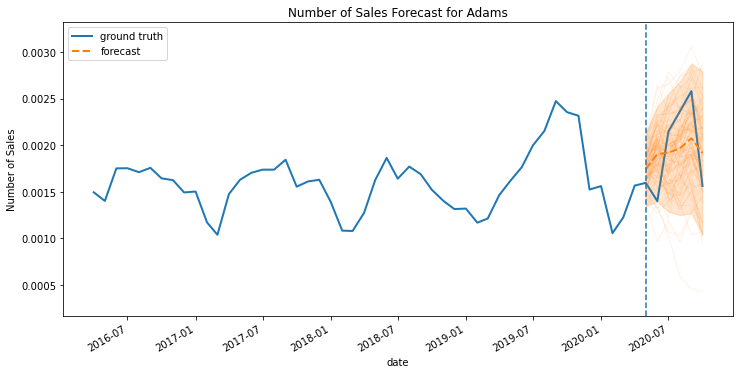

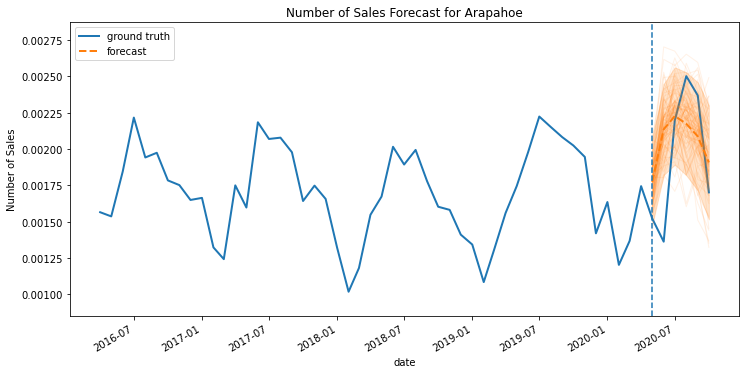

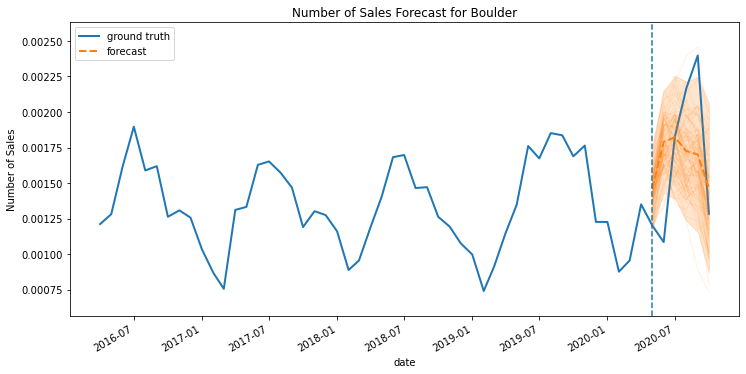

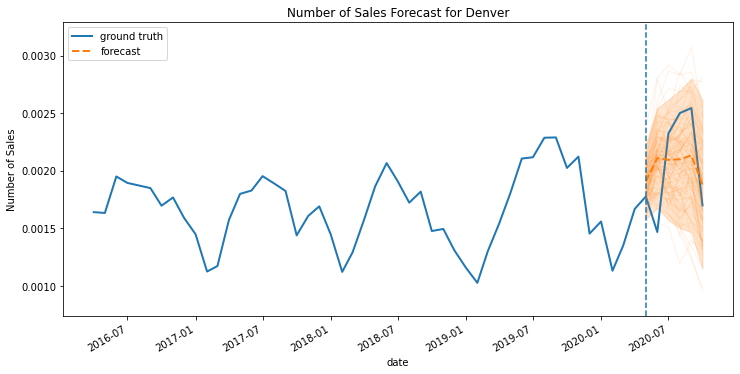

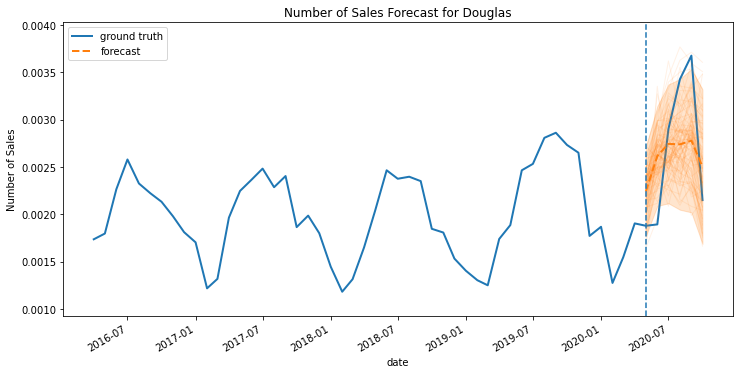

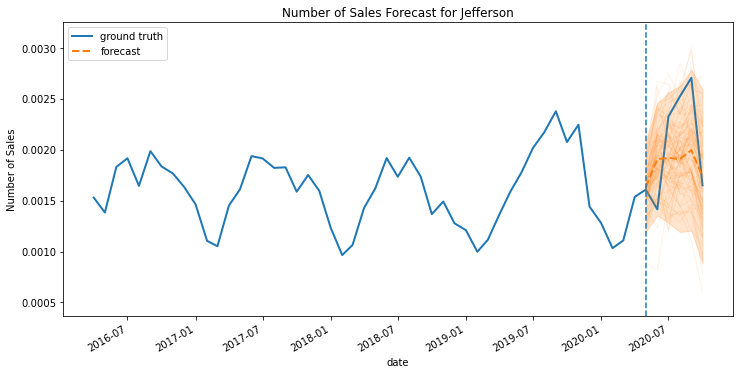

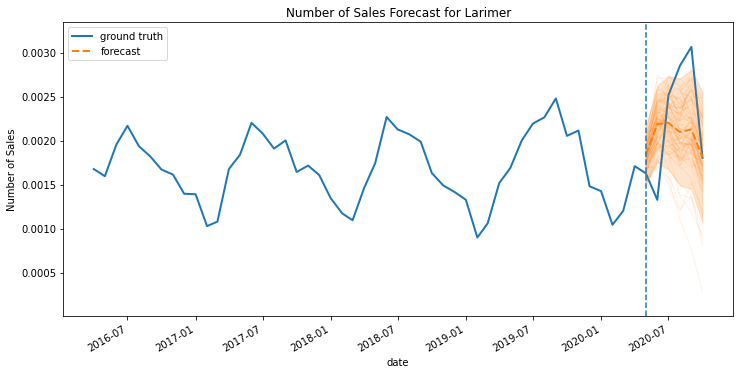

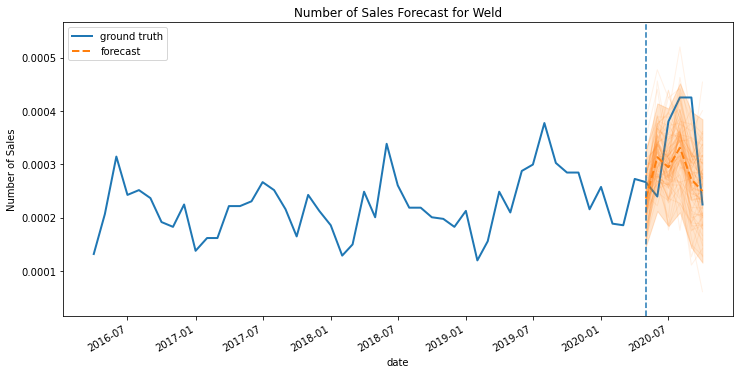

In [89]:
# Model 2 - count sale
forecast_countsale_county = {}
for idx, area in enumerate(df_monthly_population_county.county.unique()):
    forecast_countsale_county[area] = forecast_bsts(df_monthly_population_county, 'count_sale_normalized',area,'county', 
                                                     model=build_model2)

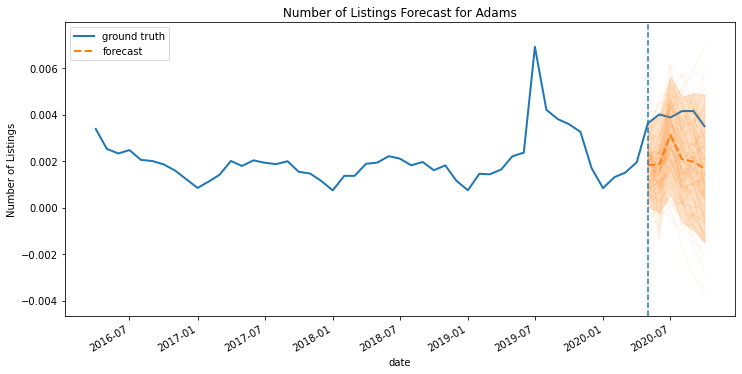

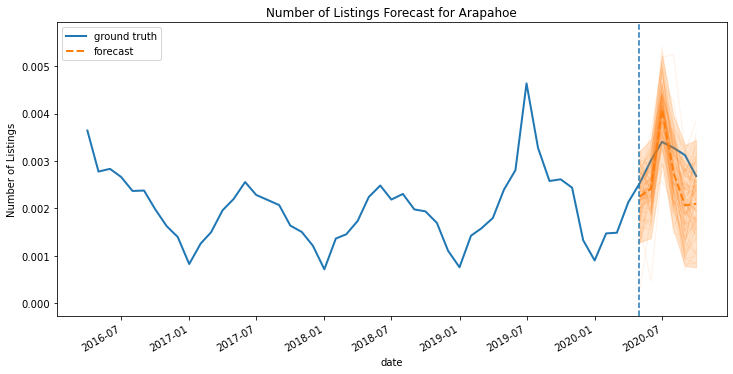

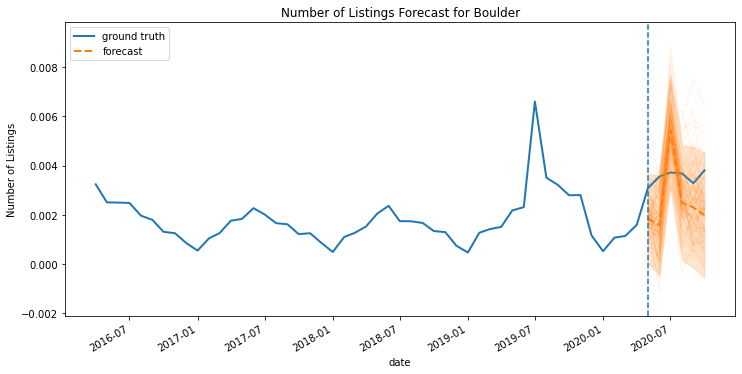

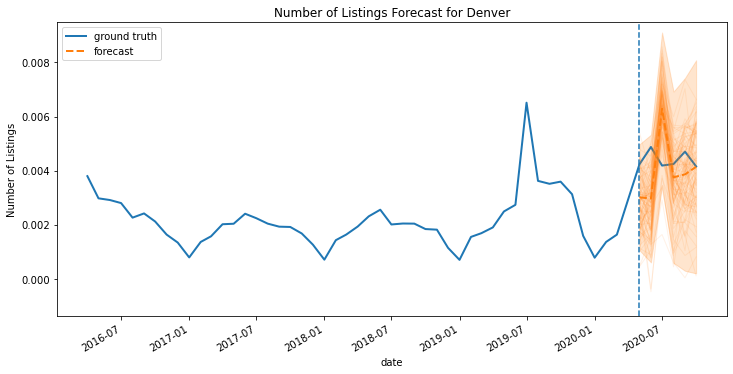

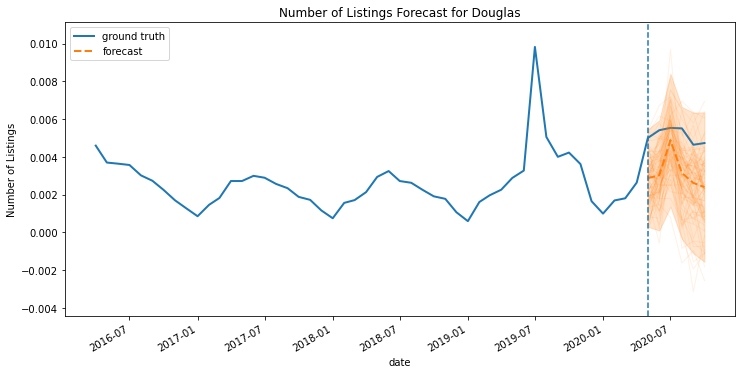

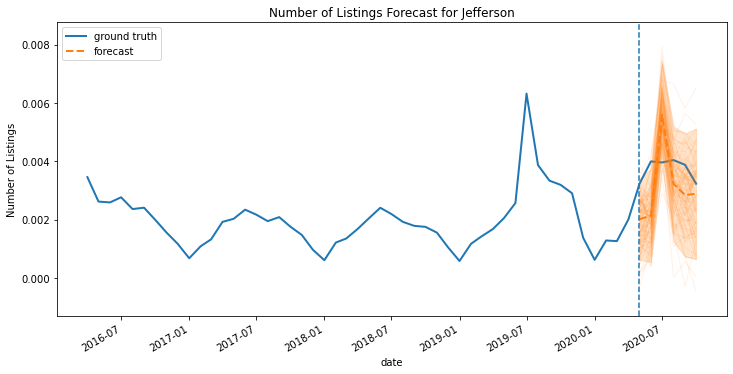

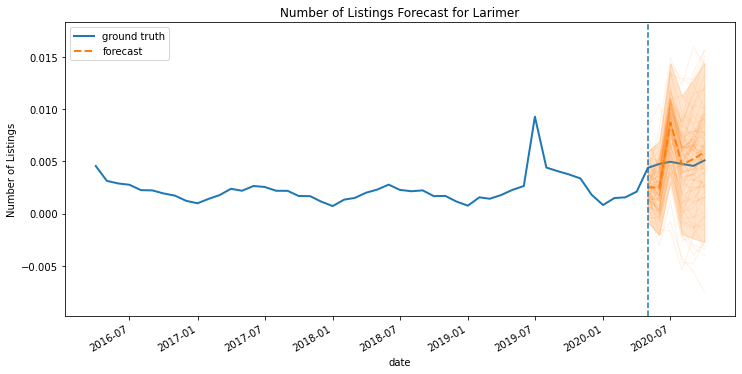

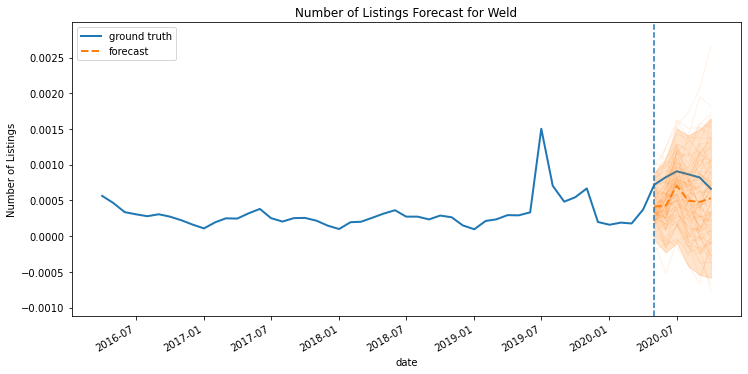

In [90]:
# Model 2 - count listing
forecast_countsale_county = {}
for idx, area in enumerate(df_monthly_population_county.county.unique()):
    forecast_countsale_county[area] = forecast_bsts(df_monthly_population_county, 'count_listing_normalized',area,'county', 
                                                     model=build_model2)